In [25]:
%load_ext autoreload
%autoreload 2
from pkg.forecast import SalesForecast
import pandas as pd
import os
import csv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
sale = 'data/sales/monthly_sales.csv'
forecasts = 'data/results/Forecasts test.csv'
headers=['product', 'date', 'forecast', 'model']
if not os.path.exists(forecasts):
    with open(forecasts, "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
sale_df_total = pd.read_csv(sale)
forecast_df = pd.read_csv(forecasts)

products_fr = pd.unique(forecast_df['product'])
products = pd.unique(sale_df_total['product'])
sale_df_total.date += 62100

In [72]:
sale_df = sale_df_total[sale_df_total['product'] == "Zytux 100"]
prod_fr = SalesForecast("Zytux 100", sale_df, forecasts)
prod_fr.preprocess_data()
prod_fr.model_selection()

c:\Users\Mohajeri.K\Forecast\src\pkg\forecast.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.sale_df.date = pd.to_datetime(self.sale_df['date'], format='%Y%m')
c:\Users\Mohajeri.K\Forecast\src\pkg\forecast.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.sale_df.sales = self.sale_df.sales.fillna(value=0)
c:\Users\Mohajeri.K\Forecast\src\pkg\forecast.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [73]:
# prod_fr.best_model_type = "Prophet"
prod_fr.predict()

17:14:41 - cmdstanpy - INFO - Chain [1] start processing
17:14:42 - cmdstanpy - INFO - Chain [1] done processing


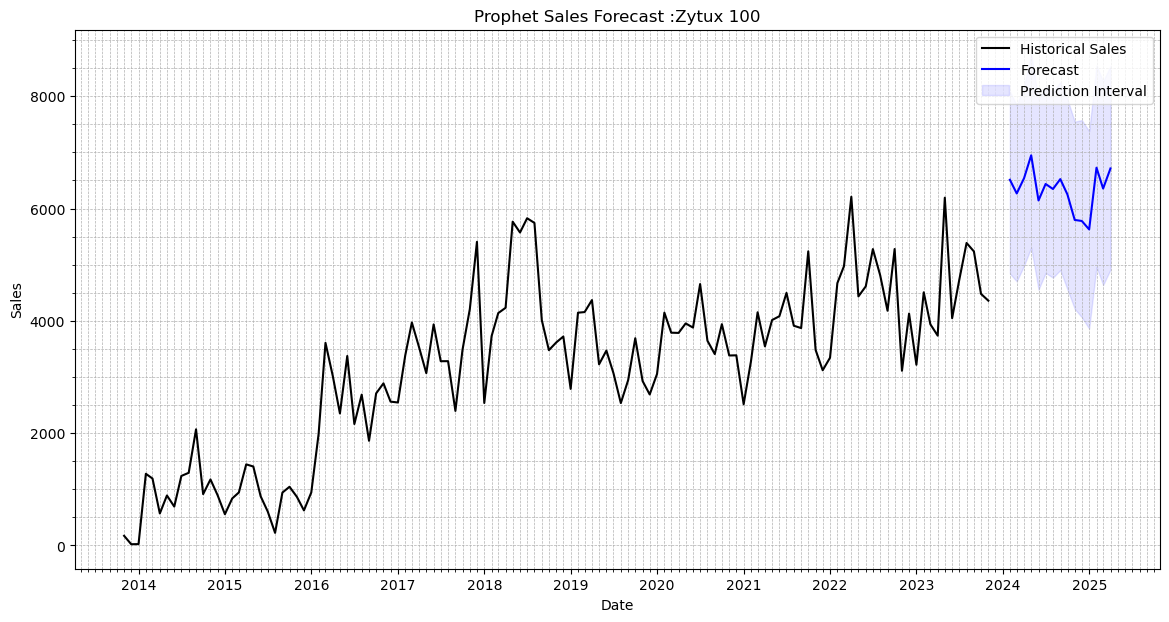

In [74]:
prod_fr.plot()